## Run models for feature selection

Created  ..\..\model_results\selected_features\rbred
Created  ..\..\models_trained\final_models\rbred
Created  ..\..\models_trained\nested_cv_models\rbred
Created  ..\..\model_results\models_evaluation\rbred


05-16-2024 07:33:14 - __feature_extraction___ - INFO - (361, 19)
05-16-2024 07:33:14 - __feature_extraction___ - INFO - 

############ Applying ElasticNet on rbred ############
 
05-16-2024 07:33:14 - __feature_extraction___ - INFO - Removing 0 records from entire dataset due that these values are nan in target variable
05-16-2024 07:33:14 - __feature_extraction___ - INFO - Finally use 300 records for feature extraction, from those are 123 cases with zero-loss or zero-reduction
05-16-2024 07:33:14 - __feature_extraction___ - INFO - Use for feature extraction 16 features to predict rbred


Dropping records with missing values


05-16-2024 07:34:43 - __feature_extraction___ - INFO - Parameter sets of best estimators outer test-sets:
05-16-2024 07:34:43 - __feature_extraction___ - INFO - Params of best model: {'model__tol': 0.3, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.1, 'model__alpha': 0.5}
05-16-2024 07:34:43 - __feature_extraction___ - INFO - Performance of best estimator


ElasticNet:  {'model__tol': 0.3, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.1, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.3, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.1, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.3, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.1, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.3, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.1, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.3, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.1, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.3, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.1, 'model__alpha': 0.5}
ElasticNet:  {'model__tol': 0.3, 'model__selection': 'rand

05-16-2024 07:34:47 - __feature_extraction___ - INFO - 
Select features based on permutation feature importance
05-16-2024 07:34:47 - __feature_extraction___ - INFO - 5 most important features: ['shp_business_limitation', 'flow velocity', 'resilience', 'building age', 'no. employees']
05-16-2024 07:34:47 - __feature_extraction___ - INFO - 
Training and evaluation of ElasticNet took 1.5376927999999999 minutes

05-16-2024 07:34:47 - __feature_extraction___ - INFO - Creating boxplots for range of performane scores from outer folds of nested cross-validation


coefs_intercept = np.append(model_intercept, list(model_coefs)) [14.3071516   0.          1.19518703  0.42388562  2.76110531  1.99513241
 -0.72199061  0.52800972  3.38599111 -0.6300205  -0.07517689  2.77504396
 -0.69318515 -0.62450589 -1.24226625  0.67403754  0.08687097]


KeyError: 'XGBRegressor'

<Figure size 2000x1000 with 0 Axes>

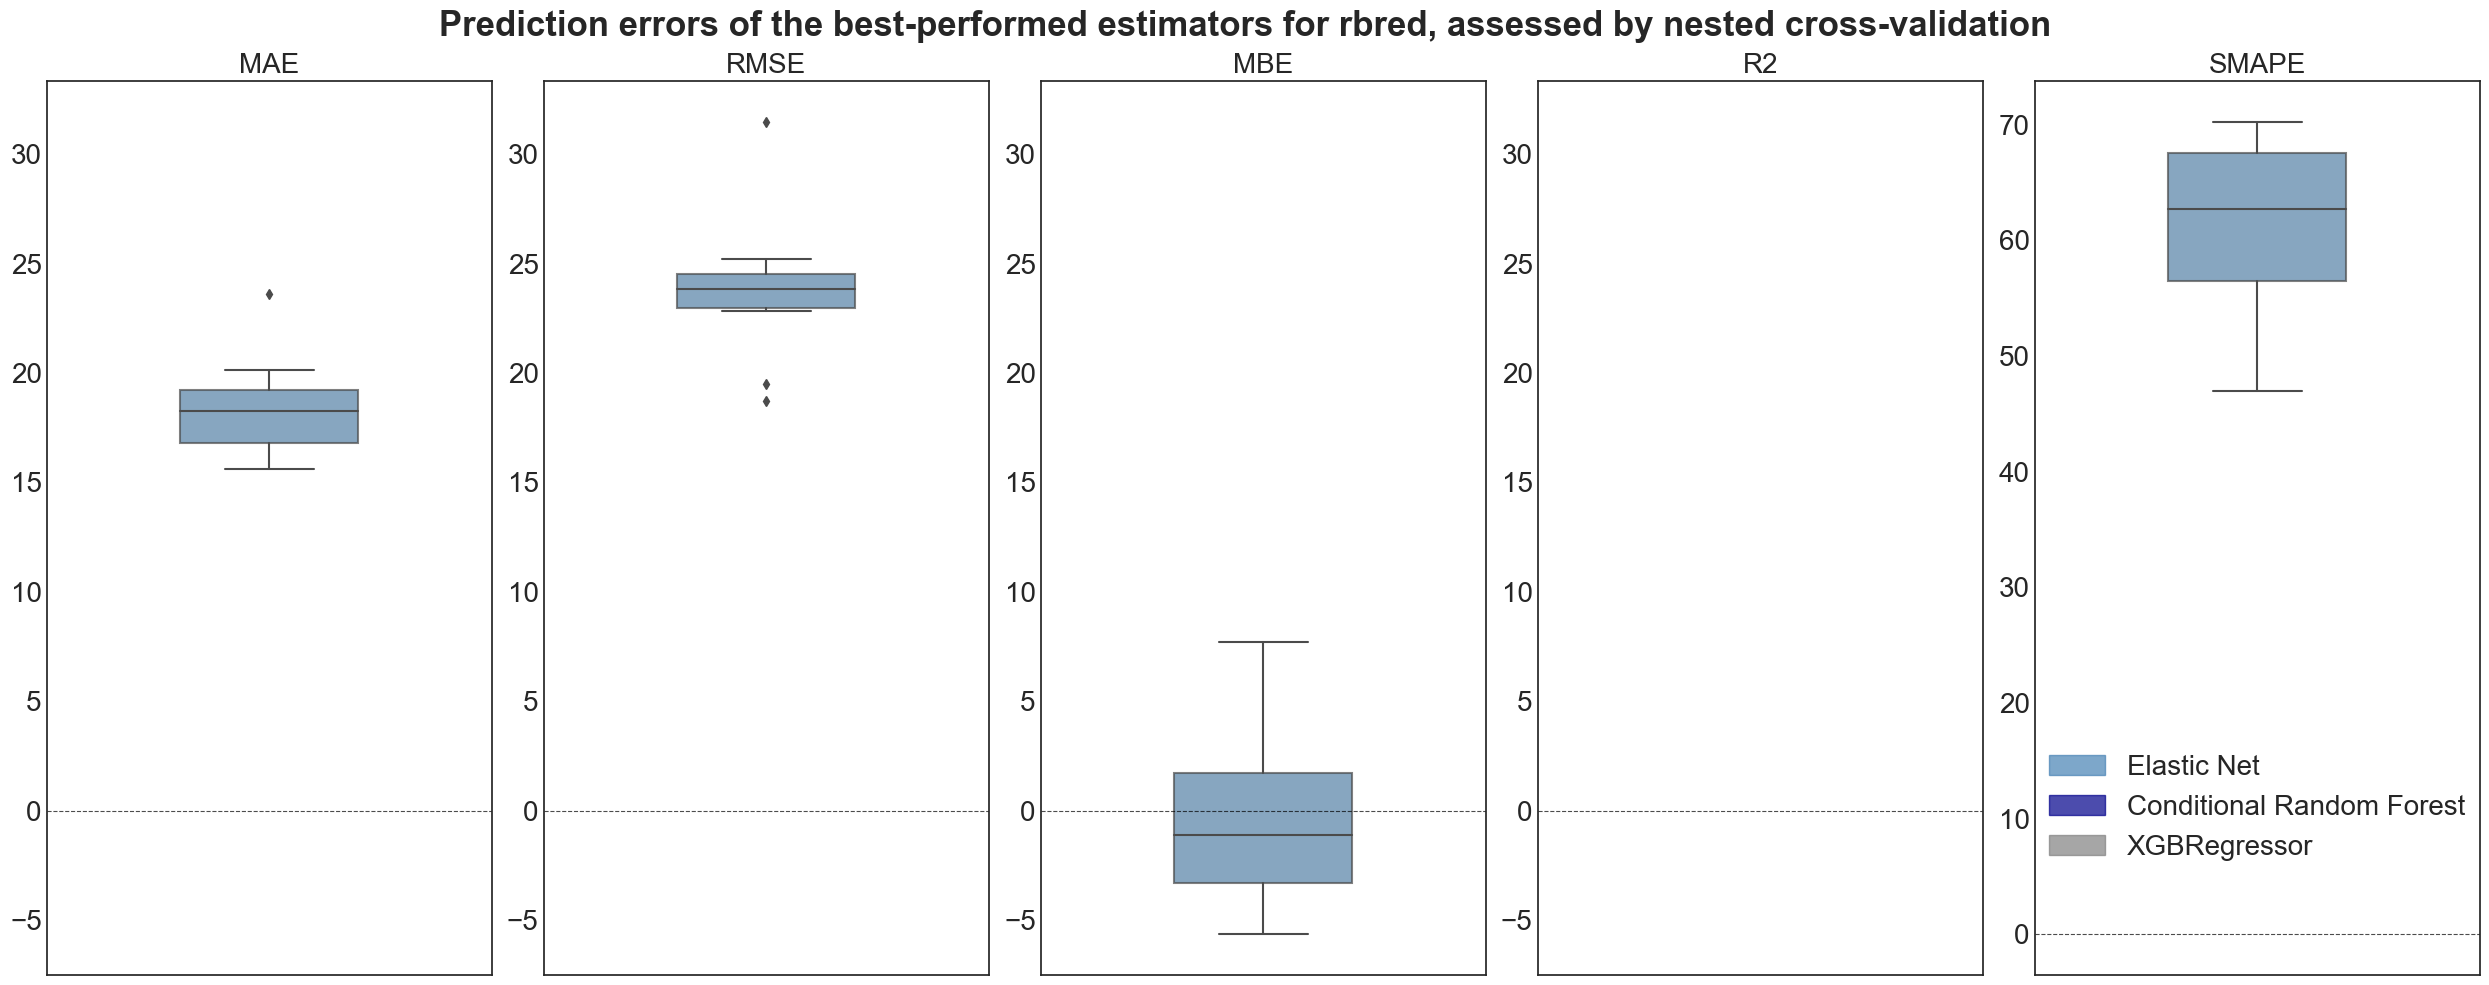

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Featue selection with ML models for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

# ## Feature selection 
# Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)
# 
# Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
# Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.
# 
# - Logistic Regression (binary rcloss)
# - Elastic Net
# - eXtreme Gradient Boosting
# - Random Forest
# 

import sys, os
from datetime import datetime
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


UTILS_PATH = os.path.join(os.path.abspath(""), "../", "utils")
sys.path.append(UTILS_PATH)

import feature_selection as fs
import training as t
import evaluation as e
import evaluation_utils as eu
import figures as f
import settings as s
# import pipelines as p
import preprocessing as pp

# p.main()  # create/update model settings
seed = 42 #s.seed

pd.set_option("display.max_columns", None)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings("ignore")



targets = [("rcloss", "degree of rcloss"), ("rbred", "rbred")]
target, target_plot = targets[1]
pred_target = f"pred_{target}"


# Get logger  # test: init application
main_logger = f"__feature_extraction___"
logger = s.init_logger(main_logger)

## settings for cv
kfolds_and_repeats = 10, 5 # 3, 1  # <k-folds, repeats> for nested cv
inner_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)
# outer_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)
outer_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=1, random_state=seed) # make same as for R nestedcv.train()


## save models and their evaluation in following folders:
INPATH_DATA = Path(s.INPATH_DATA) # input path
OUTPATH_FEATURES, OUTPATH_FINALMODELS, OUTPATH_ESTIMATORS_NCV, OUTPATH_RESULTS = [ # create output paths
    pp.create_output_dir(Path(d) / "rbred") for d in  
    [s.OUTPATH_FEATURES, s.OUTPATH_FINALMODELS, s.OUTPATH_ESTIMATORS_NCV, s.OUTPATH_EVAL]
]


## preprocessed HCMC survey data for rcloss
df_candidates = pd.read_excel(f"{INPATH_DATA}/input_data_businessreduction_tueb.xlsx")
##  use nice feature names
df_candidates.rename(columns=s.feature_names_plot, inplace=True)
# with contextlib.suppress(Exception):
#     df_candidates.drop(["hh_monthly_income_euro", "shp_content_value_euro"], axis=1, inplace=True)

 
logger.info(df_candidates.shape)

## Evaluation metrics 
score_metrics = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(eu.root_mean_squared_error, greater_is_better=False),
    "MBE": make_scorer(eu.mean_bias_error, greater_is_better=False),
    "R2": "r2",
    "SMAPE": make_scorer(eu.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}



## empty variables to store model outputs
eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 
# pipelines = ["pipe_rf", "pipe_en", "pipe_xgb"]  
pipelines = ["pipe_en"]  

## Load set of hyperparamters
hyperparams_set = pp.load_config(f"{UTILS_PATH}/hyperparameter_sets.json")


for pipe_name in pipelines:

    TIME0 = datetime.now()

    ## load model pipelines
    pipe = joblib.load(f"{UTILS_PATH}/pipelines/{pipe_name}.pkl")
 
    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    
    ## load respective hyperparameter space
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging fro model training is used , rename hyperparmeters
    if "bag" in pipe_name.split("_"):
        logger.info(f"Testing {model_name} with bagging")
        param_space = { k.replace("model", "bagging__estimator") : v for (k, v) in param_space.items()}


    logger.info( f"\n\n############ Applying {model_name} on {target} ############\n ")

    # save original df for later
    df_Xy = df_candidates

    # rm geometry column which only needed for visualization
    df_Xy = df_Xy.drop("geometry", axis=1)

    ## drop content value var due its only needed to recalculate losses after BN
    with contextlib.suppress(Exception):
        df_Xy.drop(["shp_content_value_euro"], axis=1, inplace=True)
   
  
    # get predictor names
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    ## remove zero-loss records only for combined dataset
    if target == "Target_relative_contentloss_euro":
        logger.info(f"Removing {df_Xy.loc[df_Xy[target]==0.0,:].shape[0]} zero loss records")
        df_Xy = df_Xy.loc[df_Xy[target]!=0.0,:]


    ## drop samples where target is nan
    logger.info(f"Removing {df_Xy[target].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_Xy = df_Xy[ ~df_Xy[target].isna()]

    ## Elastic Net and Random Forest: drop samples where any value is nan
    if (model_name == "ElasticNet") | (model_name == "RandomForestRegressor"):
        print("Dropping records with missing values")
        df_Xy.dropna(inplace=True)
        #df_Xy = df_Xy.apply(lambda x: x.fillna(x.median()), axis=0)
        # print("Impute records with missing values for Elastic Net or RandomForest",
        #        f"keeping {df_Xy.shape} damage cases for model training and evaluation")


    logger.info(
        f"Finally use {df_Xy.shape[0]} records for feature extraction, from those are {(df_Xy[target][df_Xy[target] == 0.0]).count()} cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]

    logger.info( f"Use for feature extraction {X.shape[1]} features to predict {target_plot}")


    ## fit model for unbiased model evaluation and for final model used for Feature importance, Partial Dependence etc.
    mf = t.ModelFitting(
        model=pipe, 
        Xy=df_Xy,
        target_name=target,
        param_space=param_space,
        tuning_score=score_metrics["MAE"], # tune by getting reducing MAE
        cv=inner_cv,
        kfolds_and_repeats=kfolds_and_repeats,
        seed=seed,
    )
    models_trained_ncv = mf.model_fit_ncv()

    # save models from nested cv and final model on entire ds
    joblib.dump(models_trained_ncv, f"{OUTPATH_ESTIMATORS_NCV}/{model_name}_{target}.joblib")
        
    ## evaluate model    
    me = e.ModelEvaluation(
        models_trained_ncv=models_trained_ncv, 
        Xy=df_Xy,
        target_name=target,
        score_metrics=score_metrics,
        cv=outer_cv,
        kfolds=kfolds_and_repeats[0],
        seed=seed,
    )
    model_evaluation_results = me.model_evaluate_ncv()

    ## reverse sklearn.cross_validate() outputted regression scores (e.g. MAE, RMSE, SMAPE, R2)
    model_evaluation_results = me.negate_scores_from_sklearn_cross_valdiate(  # TODO impl directly as method in ModelEvalaution()
        model_evaluation_results, 
        metric_names=("test_MAE", "test_MBE", "test_RMSE", "test_SMAPE"))


    ## visual check if hyperparameter ranges are good or need to be adapted
    logger.info(f"Parameter sets of best estimators outer test-sets:") 
    for i in range(len(model_evaluation_results["estimator"])):
        print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)
    print("\n")

    ## store models evaluation 
    models_scores[model_name] =  {
        k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
    } # get evaluation scores, metric names start with "test_<metricname>"



    ## Final model

    ## get  and save final model based on best MAE score during outer cv
    best_idx = list(models_scores[model_name]["test_MAE"]).index(min(models_scores[model_name]["test_MAE"]))
    final_model = model_evaluation_results["estimator"][best_idx]
    logger.info(f"Params of best model: {final_model.best_params_}") 
    final_model = final_model.best_estimator_

        
    ## print performance of best estimator   
    logger.info(f"Performance of best estimator") 
    for metric in models_scores[model_name].keys():
        print(metric, models_scores[model_name][metric][best_idx])
        

    final_models_trained[model_name] = final_model 
    joblib.dump(final_model, f"{OUTPATH_FINALMODELS}/{model_name}_{target}.joblib")


    ## get predictions of final model from respective outer test set
    test_set_best = df_Xy.iloc[model_evaluation_results["indices"]["test"][best_idx], :]
    finalmodel_X_test = test_set_best.drop(target, axis=1)
    finalmodel_y_test = test_set_best[target]
    finalmodel_y_pred = final_model.predict(finalmodel_X_test)  # get predictions from final model for its test-set (should be the same as done during model evluation with ncv)


    ## Learning curve of train and test set of final model
    train_set_best = df_Xy.iloc[model_evaluation_results["indices"]["train"][best_idx], :]
    f.plot_learning_curves(
        final_model, train_set_best, test_set_best, target,
        f"{OUTPATH_RESULTS}/learning_curves{target}_{model_name}.png", 
        model_name)
    
    
    ## Feature importance of best model on its test set
    importances = me.permutation_feature_importance(
        final_model, 
        finalmodel_X_test, finalmodel_y_test, 
        repeats=5)


    ## regression coefficients for linear models from best estimator
    with contextlib.suppress(Exception):

        models_coef[model_name] = me.calc_regression_coefficients(final_model, finalmodel_y_test, finalmodel_y_pred)
        outfile = f"{OUTPATH_RESULTS}/regression_coefficients_{model_name}_{target}.xlsx"
        models_coef[model_name].round(3).to_excel(outfile, index=True)
        logger.info(f"Regression Coefficients:\n {models_coef[model_name].sort_values('probabilities', ascending=False)} \n .. saved to {outfile}")
        
        ## check if any regression coefficient is significant 
        if np.min(models_coef[model_name]["probabilities"]) >= 0.05:
            ## non permanent decorator, extending with creation of log file for warnings
            logger = s.decorate_init_logger(s.init_logger)("__warning_coefs__") 
            logger.info("non of the regression coefficients is significant")
            logger = s.init_logger(main_logger)  # reset to previous state




    # ## Collect all models and their evaluation

    ## store fitted models and their evaluation results for later 
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    predicted_values[model_name] = me.residuals  # y_true, y_pred and residual from outer cv

    ## store Feature Importances of each model
    logger.info("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # averaged importnace scores across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")
    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    logger.info(f"5 most important features: {df_feature_importances.iloc[:5].index.to_list()}")


    logger.info(
    f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds() / 60} minutes\n"
    )
            


## Plot performance ranges of all evaluated estimators from outer cross-validation 
logger.info("Creating boxplots for range of performane scores from outer folds of nested cross-validation")
f.boxplot_outer_scores_ncv(
    models_scores,
    outfile=f"{OUTPATH_RESULTS}/boxplot_scores4ncv_{target}.png",
    target_name=target_plot)


# store avergaed scores and std for later usage
## TODO remove overhead  -> store avergaed scores and std during loop
xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
xgb_model_evaluation_std = pd.DataFrame(models_scores["XGBRegressor"]).std(axis=0)   # get respective standard deviations
crf__model_evaluation = pd.DataFrame(models_scores["RandomForestRegressor"]).mean(axis=0)
crf_model_evaluation_std = pd.DataFrame(models_scores["RandomForestRegressor"]).std(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).mean(axis=0)
en_model_evaluation_std = pd.DataFrame(models_scores["ElasticNet"]).std(axis=0)


model_evaluation = pd.concat([en_model_evaluation, en_model_evaluation_std, crf__model_evaluation, crf_model_evaluation_std, xgb_model_evaluation, xgb_model_evaluation_std], axis=1)
model_evaluation.columns = ["ElasticNet_score", "ElasticNet_score_std", "RandomForestRegressor_score", "RandomForestRegressor_score_std", "XGBRegressor_score", "XGBRegressor_score_std"]


## rename metrics
model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"{OUTPATH_RESULTS}/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
logger.info(f"Outer evaluation scores of nested cross-validation (mean) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")




## Feature Importances 

#### prepare Feature Importances 
## Have the same feature importance method across all applied ML models
## Weight Importances by model performance on outer loop (mean MAE)
## **Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)**

## weight FI scores based on performance ; weigth importances from better performed models stronger
model_weights =  {
    "XGBRegressor_importances" : np.mean(models_scores["XGBRegressor"]["test_MAE"]),
    "ElasticNet_importances" : np.mean(models_scores["ElasticNet"]["test_MAE"]),
    "RandomForestRegressor_importances" : np.mean(models_scores["RandomForestRegressor"]["test_MAE"]),
}
df_feature_importances_w = fs.calc_weighted_sum_feature_importances(df_feature_importances, model_weights)


####  Plot Feature importances

## the best model has the highest weighted feature importance value
df_feature_importances_plot = df_feature_importances_w

## drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot.weighted_sum_importances > 0.0, : ] 

## plot stacked FI
f.plot_stacked_feature_importances(
    df_feature_importances_plot[["ElasticNet_importances_weighted", "RandomForestRegressor_importances_weighted", "XGBRegressor_importances_weighted",]],
    target_name=target_plot,
    model_names_plot = ("Elastic Net", "RandomForestRegressor", "XGBRegressor"),
    outfile=f"{OUTPATH_RESULTS}/feature_importances_{target}.png"
)


## Save final feature space 
### The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
logger.info(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
logger.info(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_w["weighted_sum_importances"].sort_values(ascending=False).index##[:10]

## save important features, first column contains target variable
fs.save_selected_features(
    df_candidates.drop(target, axis=1), # TODO adpat function that target is only once added
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"{OUTPATH_FEATURES}/final_predictors_{target}.xlsx"
)



In [4]:
## Partial dependence
## PDP shows the marginal effect that one or two features have on the predicted outcome.


## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "ElasticNet", "ElasticNet"]}

for model_name in ["ElasticNet", "ElasticNet", "ElasticNet"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]

    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            # "percentiles" : (0.05, .95), # causes NAN for some variables for XGB if (0, 1)
            "scale"  : True
        }  
        
        # get Partial dependences 
        partial_dep = me.get_partial_dependence(**features_info)
        
        # R partial func scales predictor values differenctly, thus rescale them back to range between 0 and 1
        scaler = MinMaxScaler()
        partial_dep[predictor_name] = scaler.fit_transform(partial_dep[[predictor_name]])
          
        pdp_features[model_name][predictor_name] = partial_dep




In [6]:
pdp_features["ElasticNet"]

{'inundation duration':     inundation duration       yhat
 0              0.000000  18.400971
 1              0.001251  18.400971
 2              0.003336  18.400971
 3              0.005421  18.400971
 4              0.007506  18.400971
 5              0.011676  18.400971
 6              0.015847  18.400971
 7              0.020017  18.400971
 8              0.024187  18.400971
 9              0.028357  18.400971
 10             0.032527  18.400971
 11             0.036697  18.400971
 12             0.040867  18.400971
 13             0.049208  18.400971
 14             0.053378  18.400971
 15             0.061718  18.400971
 16             0.070058  18.400971
 17             0.090909  18.400971
 18             0.095079  18.400971
 19             0.099249  18.400971
 20             0.103420  18.400971
 21             0.124270  18.400971
 22             0.136781  18.400971
 23             0.161802  18.400971
 24             0.199333  18.400971
 25             0.291076  18.400971
 26  

## Improve PDP funcion

In [162]:

def plot_partial_dependence(df_pd_feature, feature_name:str, partial_dependence_name:str, categorical:list, outfile, **kwargs):
    """
    Creates plots for partial dependencies for multiple models
    :param df_pd_feature: df_pd_feature
    :param feature_name: name of feature (x-axis)
    :param partial_dependence_name: name of target (y-axis)
    :param feature_names: List of features
    :param categorical (list): list of features which are categorical TODO make as boolean
    :return: plot and png of PDP
    """
    if feature_name in categorical:
        sns.barplot(
            data=df_pd_feature, 
            x=df_pd_feature[feature_name], 
            y=df_pd_feature[partial_dependence_name], 
            **kwargs
        )
    else:      
        sns.lineplot(
            data=df_pd_feature, 
            x=df_pd_feature[feature_name], 
            y=df_pd_feature[partial_dependence_name], 
            legend=False,
            **kwargs
        )

    kwargs["ax"].set_aspect('auto', adjustable='box')
    # kwargs["ax"].set_aspect('equal', adjustable='box')
    #kwargs["ax"].get_xaxis().set_visible(False)
    # plt.xticks(fontsize=15)
    # plt.yticks(fontsize=15)

    # kwargs["ax"].set_xlabel(feature_name, fontsize=18)
    # kwargs["ax"].set_ylabel("")
    
    # ax.get_yaxis().set_visible(True)

    kwargs["ax"].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='on',      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom='off'  # labels along the bottom edge are off)
        )
    kwargs["ax"].tick_params(
        axis='y',
        which='both',
        left='on',
        right=False,
    )
    
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    



### Example of separate PDP (one plot for each single model)

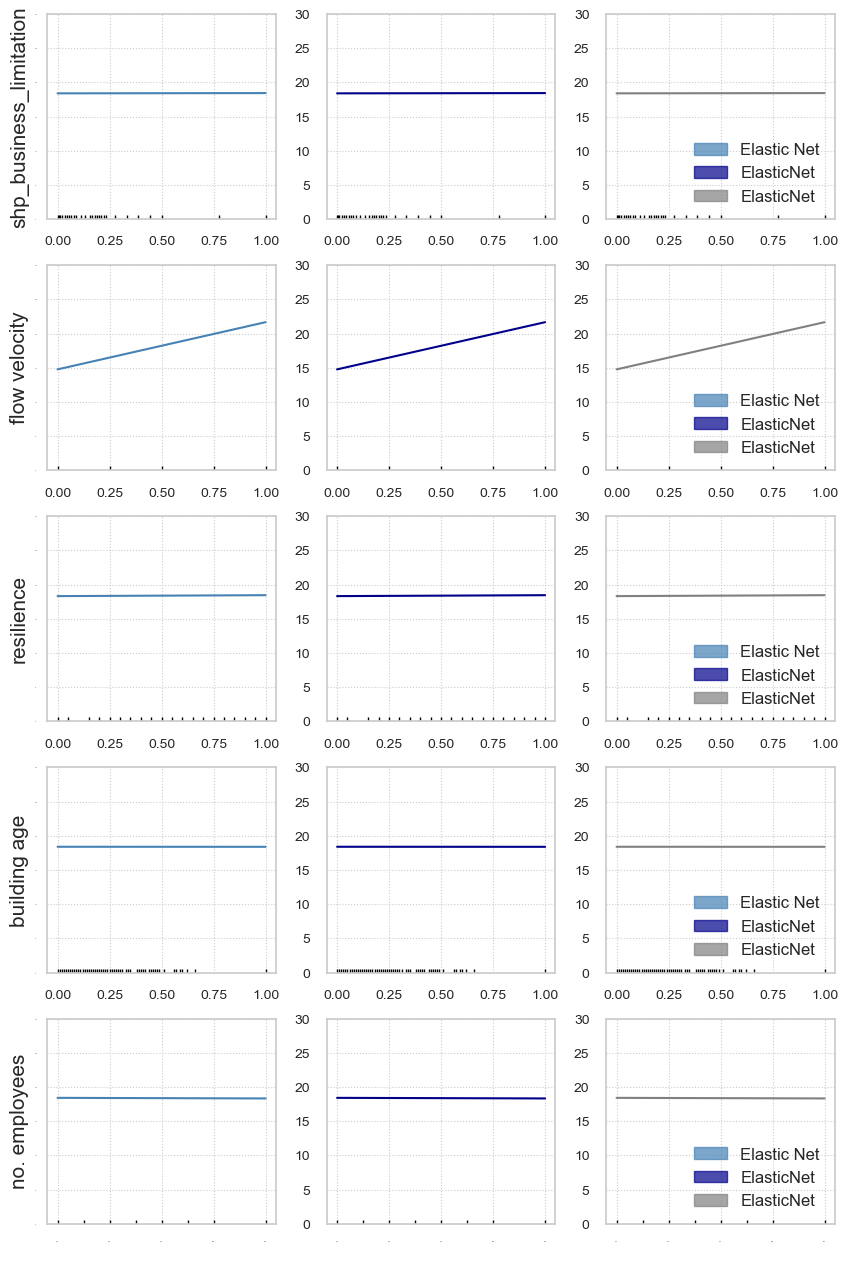

In [166]:
## Plot PDP

# most_important_features = df_feature_importances_plot.sort_values("weighted_sum_importances", ascending=False).index
most_important_features = df_feature_importances.index
categorical = [] # e.g. ["flowvelocity", "further_variables .."]
ncols = 3
nrows = len(most_important_features[:5])  # currently plots the 5 most important features
idx = 0

plt.figure(figsize=(12, 18))

## create PDP for all three models
for feature in most_important_features[:5]:

    for model_name, color, idx_col in zip(["ElasticNet", "ElasticNet", "ElasticNet"], ["steelblue", "darkblue", "grey"], [0, 1, 2]):

        # idx position of subplot and plot settings
        sns.set_style("whitegrid", {"grid.linestyle": ":"})
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col, aspect="equal") # aspect="equal"= square plots
        feature_info = {"color" : color, "ax" : ax} 

        ## partial dependence of one feature for one model to plot
        df_pd_feature = pdp_features[model_name][feature]  
        
        # plot
        p = plot_partial_dependence(
            df_pd_feature, 
            feature_name=feature, 
            partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"{OUTPATH_RESULTS}/pdp_{target}.png",
            **feature_info
            )
        p

        # rugs show the distirbution of the feature values
        sns.rugplot(df_pd_feature, x=feature, height=.02, color="black")

        ## default plot settings (later shown only for inner frames)
        plt.subplots_adjust(top=0.7, right=0.7)
        plt.ylim(0, 30)            # limit y axis 
        # center ticklables by default with equal spacing between two plots
        visible_ticks = {"top": False, "right": False}
        plt.tick_params(axis="both", pad=12, **visible_ticks)  # pad= equal spacing between two plots
        # font size of ticks
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        # hide by default x and y labels (plot feautre names only for outer frame)
        plt.xlabel(" ")
        plt.ylabel(" ")
        
        ## suppress x and y axis tick labels for outer frame
        # adpat for first col
        if idx_col == 0:
            plt.ylabel(feature, fontsize=15)
            plt.tick_params(axis="y", which="both", pad=8)  # pad= space tick - axis; which= minor and major ticks
            plt.yticks(fontsize=0)  # hide outer y ticklabels
        # adpat for last row
        if (idx == 12) or (idx == 13) or (idx == 14):
            plt.xticks(fontsize=0)  # hide outer x ticklabels (last row)
    
    ## define legend for last plot in each row
    top_bar = mpatches.Patch(color="steelblue", label="Elastic Net", alpha=.7)  #TODO update with s.color_palette_models from settings
    middle_bar = mpatches.Patch(color="darkblue", label="ElasticNet", alpha=.7)
    bottom_bar = mpatches.Patch(color="grey", label="ElasticNet", alpha=.7)
    plt.legend(handles=[top_bar, middle_bar, bottom_bar], loc="lower right", fontsize=12)

    ## jump to new row
    idx = idx + 3



In [ ]:

# ### Empirical ~ predicted
# ## use y_pred cross-valdiated from outer folds, mulitplied by 100 for more readable output
# for k,v in predicted_values.items():
#     print(f"\n{k} predicted target from cross-valdiated outer folds:")
#     print(eu.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# # ### Plot prediction error from outer cv
# f.plot_residuals(
#     df_residuals=predicted_values, 
#     model_names_abbreviation=["ElasticNet", "RandomForest", "XGBRegressor"],  
#     model_names_plot=["Elastic Net", "Random Forest", "XGBoost"],
#     outfile=f"../../model_results/models_evaluation/rbred/residuals_{target}.png"
# )

